# Explication du Code : `earlystopping_pynb.py`

Ce fichier contient une implémentation d'une classe `EarlyStopping` utilisée pour arrêter prématurément l'entraînement d'un modèle de machine learning lorsque la performance sur un ensemble de validation cesse de s'améliorer. Voici une explication détaillée des différentes parties du code :

## Importations

```python
import numpy as np
import torch


# Aperçu du Code

Ce code implémente un régresseur à noyau utilisant la méthode de Landweber avec une règle d'arrêt basée sur la différenciation privée (DP).

## Importations

- **numpy** : Opérations mathématiques et manipulation des tableaux.
- **matplotlib.pyplot** : Tracé de graphiques.
- **math** : Fonctions mathématiques de base.

## Fonctions et Méthodes

- **`gaussian_kernel(X1, X2, width)`**
  - Calcule la matrice de Gram pour un noyau gaussien.

- **Classe `KernelRegressorSpectralLandweberDP`**
  - **`__init__(self, X, Y, kernel_width)`**
    - Initialise le régresseur avec les données d'entraînement et les paramètres du noyau.
  - **`alpha_t(self, t)`**
    - Calcule les coefficients alpha à l'itération `t`.
  - **`predict_t(self, X_new, t)`**
    - Prédit les valeurs pour de nouvelles données `X_new` à l'itération `t`.
  - **`residual_norm_train_t(self, t)`**
    - Calcule la norme du résidu d'entraînement à l'itération `t`.
  - **`residual_norm_test_t(self, X_test, Y_test_true, t)`**
    - Calcule la norme du résidu de test à l'itération `t`.
  - **`find_tau_DP(self, sigma, max_t=300)`**
    - Trouve l'itération d'arrêt basée sur la règle DP.

Arrêt DP à t=11


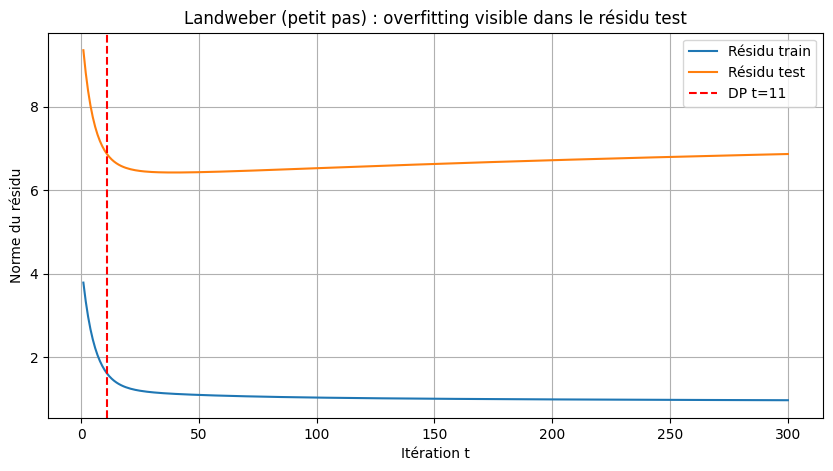

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import math

def gaussian_kernel(X1, X2, width):
    """Matrice de Gram pour un noyau Gaussien."""
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            diff = X1[i] - X2[j]
            K[i,j] = np.exp(-np.sum(diff**2)/(2*width**2))
    return K

class KernelRegressorSpectralLandweberDP:
    """
    Landweber spectral + Règle d'arrêt DP.
    On garde le "résidu train" = ||r_t(K)*Y||, et on définit
    un "résidu test" = || f^(t)(X_test) - f_true(X_test) || pour observer l'overfitting.

    Petit pas: eta = 0.1 / lmax, max_t grand => on peut voir la remontée du résidu test si sur-apprentissage.
    """
    def __init__(self, X, Y, kernel_width):
        self.X = X
        self.n = X.shape[0]
        if Y.ndim == 1:
            Y = Y.reshape(-1,1)
        self.Y = Y
        self.kernel_width = kernel_width

        # Matrice de Gram
        self.K = gaussian_kernel(X, X, kernel_width)

        # Diagonalisation
        vals, vecs = np.linalg.eigh(self.K)
        idx = np.argsort(vals)[::-1]
        self.lambdas = vals[idx]
        self.Q = vecs[:, idx]

        # Valeur propre max
        self.lmax = max(self.lambdas[0], 1e-14)

        # Petit pas
        self.eta = 0.2 / self.lmax

        # Pré-calc Q^T Y
        self.QTY = self.Q.T @ self.Y

    # ---------------------------
    # Formules Landweber
    # ---------------------------
    def alpha_t(self, t):
        """
        alpha^(t) = g_t(K)*Y, avec g_t(l) = (1/l)[1 - (1 - eta*l)^t].
        """
        gvals = []
        for l in self.lambdas:
            if l < 1e-14:
                gvals.append(0.0)
            else:
                gvals.append( (1.0/l)*(1.0 - (1.0 - self.eta*l)**t ) )
        G = np.diag(gvals)
        tmp = G @ self.QTY
        alpha = self.Q @ tmp
        return alpha  # (n,1)

    def predict_t(self, X_new, t):
        """
        f^(t)(X_new) = somme_j alpha_j^(t) * k(X_new, X_j).
        """
        alpha = self.alpha_t(t)
        K_new = gaussian_kernel(X_new, self.X, self.kernel_width)
        return (K_new @ alpha).ravel()

    # ---------------------------
    # Résidu d'apprentissage (train)
    # ---------------------------
    def residual_norm_train_t(self, t):
        """
        || r_t(K)*Y ||_2 = || (I - K*g_t(K))Y ||_2 = ||Q diag((1-eta*l)^t) Q^T Y||_2
        """
        rvals = (1.0 - self.eta*self.lambdas)**t
        R = np.diag(rvals)
        tmp = R @ self.QTY
        rvec = self.Q @ tmp
        return float(np.sqrt(np.sum(rvec**2)))

    # ---------------------------
    # Résidu (erreur) test
    # ---------------------------
    def residual_norm_test_t(self, X_test, Y_test_true, t):
        """
        Définit la norme L2 de la différence
          || f^(t)(X_test) - f_true(X_test) ||_2,
        pour observer l'overfitting.
        """
        Y_pred = self.predict_t(X_test, t)
        diff = Y_pred - Y_test_true.ravel()
        return float(np.sqrt(np.sum(diff**2)))

    # ---------------------------
    # Règle d'arrêt DP
    # ---------------------------
    def find_tau_DP(self, sigma, max_t=300):
        """
        On arrête à la 1ère itération t s.t. ||r_t(K)Y||_2 <= sqrt(n)*sigma
        """
        threshold = np.sqrt(self.n)*sigma
        for t in range(1, max_t+1):
            if self.residual_norm_train_t(t) <= threshold:
                return t
        return max_t

# --------------------------------------------------------------------------
# Exemple d'utilisation : on montre le résidu train qui descend, et le résidu test qui peut remonter
# --------------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)

    # Paramètres
    n = 30
    sigma = 0.3
    kernel_width = 0.2
    max_t = 300  # grand pour laisser le temps d'observer l'overfitting (éventuel)

    # Données train
    def ftrue(x):
        return np.sin(x)

    X_train = np.sort(np.random.uniform(-math.pi, math.pi, (n,1)), axis=0)
    Y_train = ftrue(X_train) + sigma*np.random.randn(n,1)

    # Données test (sans bruit pour voir clairement la différence)
    X_test = np.linspace(-1.5*math.pi, 1.5*math.pi, 200).reshape(-1,1)
    Y_test_true = ftrue(X_test)

    # Création du modèle
    model = KernelRegressorSpectralLandweberDP(X_train, Y_train, kernel_width)

    # Courbes
    t_vals = range(1, max_t+1)
    residual_train_list = []
    residual_test_list = []
    for t in t_vals:
        # Résidu train
        r_train = model.residual_norm_train_t(t)
        residual_train_list.append(r_train)
        # Résidu test
        r_test = model.residual_norm_test_t(X_test, Y_test_true, t)
        residual_test_list.append(r_test)

    # DP
    tau_DP = model.find_tau_DP(sigma, max_t=max_t)
    print(f"Arrêt DP à t={tau_DP}")

    # Affichage
    plt.figure(figsize=(10,5))
    plt.plot(t_vals, residual_train_list, label="Résidu train")
    plt.plot(t_vals, residual_test_list, label="Résidu test")
    plt.axvline(tau_DP, color='red', ls='--', label=f"DP t={tau_DP}")
    plt.xlabel("Itération t")
    plt.ylabel("Norme du résidu")
    plt.title(f"Landweber (petit pas) : overfitting visible dans le résidu test")
    plt.grid(True)
    plt.legend()
    plt.show()


In [4]:
%pip install numpy scipy matplotlib pandas scikit-learn seaborn jupyter notebook ipython sympy statsmodels pillow requests tqdm


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 217.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 404.2 kB/s eta 0:00:00
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
    --------------------------------------- 0.6/41.2 MB 13.3 MB/s eta 0:00:04
   - -------------------------------------- 1.6/41.2 MB 16.9 MB/s eta 0:00:03
   -- ------------------------------------- 2.2/41.2 MB 17.7 MB/s eta 0:00:03
   -- ------------------------------------- 2.8/41.2 MB 16.4 MB/s eta 0:00:03
   ---- ----------------------------------- 4.2/41.2 MB 19.0 MB/s eta 0:00:02
   ----- -----------------


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\djake\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Aperçu du Code

Ce code implémente un régresseur à noyau utilisant la méthode de Landweber avec une règle d'arrêt basée sur la différenciation privée (SDP), en utilisant un lissage de type Landweber.

## Importations

- **numpy** : Opérations mathématiques et manipulation des tableaux.
- **matplotlib.pyplot** : Tracé de graphiques.
- **math** : Fonctions mathématiques de base.

## Fonctions et Méthodes

- **`gaussian_kernel(X1, X2, width)`**
  - Calcule la matrice de Gram pour un noyau gaussien.

- **Classe `KernelRegressorSpectralLandweberSDP`**
  - **`__init__(self, X, Y, kernel_width, T_smooth_iterations)`**
    - Initialise le régresseur avec les données d'entraînement et les paramètres du noyau.
  - **`alpha_t(self, t)`**
    - Calcule les coefficients alpha à l'itération `t`.
  - **`predict_t(self, X_new, t)`**
    - Prédit les valeurs pour de nouvelles données `X_new` à l'itération `t`.
  - **`residual_norm_test_t(self, X_test, Y_test_true, t)`**
    - Calcule la norme du résidu de test à l'itération `t`.
  - **`calculate_g_tilde_Landweber_T_diag(self)`**
    - Calcule la matrice diagonale pour le lissage Landweber.
  - **`calculate_L_n(self)`**
    - Calcule la matrice de lissage `L_n`.
  - **`squared_smoothed_residual_L2_norm_t(self, t)`**
    - Calcule la norme L2 au carré du résidu lissé sur l'ensemble d'entraînement.
  - **`calculate_N_tilde_g_T(self)`**
    - Calcule la dimension effective lissée.
  - **`find_tau_SDP(self, sigma, max_t=600)`**
    - Trouve l'itération d'arrêt basée sur la règle SDP.

Initializing model...
INFO: Using Landweber-type smoothing for SDP with T=10 iterations and eta=0.0211
Model initialized.
Effective dimension N_n^g(T) (Landweber smoothing) = 5.0392
Calculating residuals for each iteration...
  Iteration 100/800
  Iteration 200/800
  Iteration 300/800
  Iteration 400/800
  Iteration 500/800
  Iteration 600/800
  Iteration 700/800
  Iteration 800/800
Residual calculation finished.
Finding SDP stopping iteration (Landweber smoothing)...
SDP stopping iteration found: t = 23


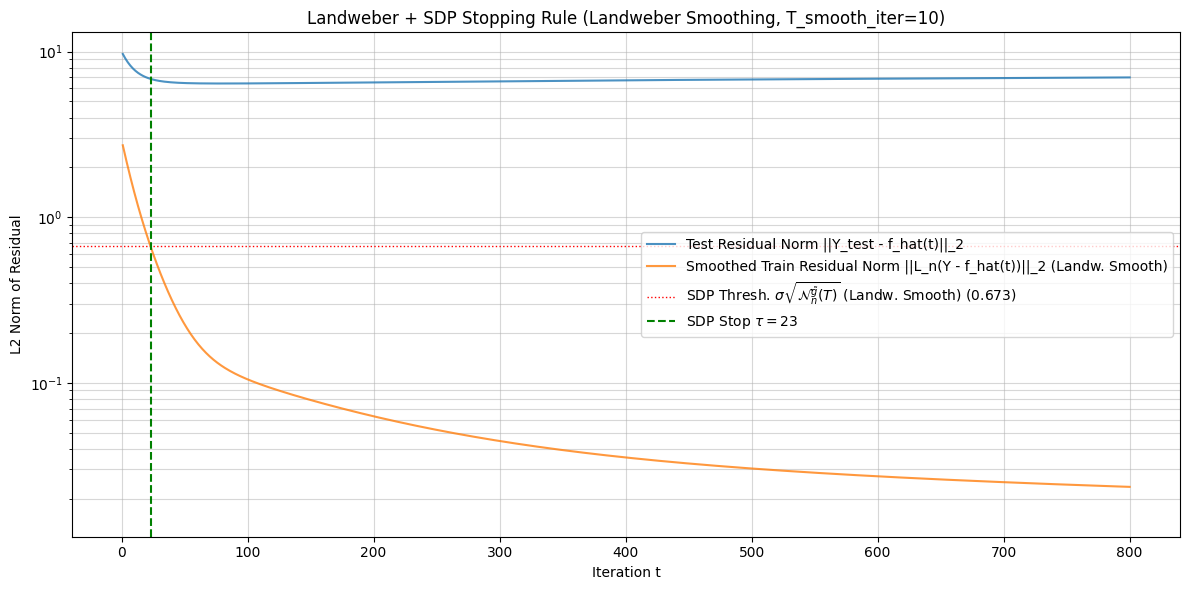

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def gaussian_kernel(X1, X2, width):
    """Matrice de Gram pour un noyau Gaussien."""
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            diff = X1[i] - X2[j]
            K[i,j] = np.exp(-np.sum(diff**2)/(2*width**2))
    return K

class KernelRegressorSpectralLandweberSDP:
    """
    Régresseur noyau par Landweber spectral.
    Inclut le calcul de la règle d'arrêt SDP.
    MODIFIÉ : Utilise un lissage de type Landweber pour SDP.
    """
    def __init__(self, X, Y, kernel_width, T_smooth_iterations):
        # T_smooth_iterations: Interprété comme le nombre d'itérations
        #                    pour le filtre de lissage Landweber g_tilde_T
        self.X = X
        self.n = X.shape[0]
        if Y.ndim == 1:
            Y = Y.reshape(-1,1)
        self.Y = Y
        self.kernel_width = kernel_width
        # T_smooth_iterations remplace T_smooth, représente 'T' itérations
        self.T_smooth_iterations = int(max(1, T_smooth_iterations)) # Assure T >= 1 entier

        # Matrice de Gram
        self.K = gaussian_kernel(X, X, kernel_width)

        # Diagonalisation K = Q Lambda Q^T
        try:
            vals, vecs = np.linalg.eigh(self.K)
        except np.linalg.LinAlgError:
             print("Eigendecomposition failed. Matrix might be ill-conditioned.")
             epsilon = 1e-10
             vals, vecs = np.linalg.eigh(self.K + epsilon * np.eye(self.n))

        vals = np.maximum(vals, 0)
        idx = np.argsort(vals)[::-1]
        self.lambdas = vals[idx]
        self.Q = vecs[:, idx]

        # Valeur propre max
        self.lmax = max(self.lambdas[0], 1e-14)

        # Petit pas eta pour Landweber (principal ET lissage)
        # Utilisation du même eta pour les deux par simplicité
        self.eta = 0.01 / self.lmax

        # Pré-calcul Q^T Y
        self.QTY = self.Q.T @ self.Y

        # --- Composants pour le lissage SDP (Type Landweber) ---
        # ATTENTION: Utilise Landweber pour g_tilde_T, T=T_smooth_iterations
        #          Ceci s'écarte de l'analyse principale du papier (Tikhonov)
        print(f"INFO: Using Landweber-type smoothing for SDP with T={self.T_smooth_iterations} iterations and eta={self.eta:.4f}")
        self.g_tilde_T_diag = self.calculate_g_tilde_Landweber_T_diag() # Modifié
        self.L_n = self.calculate_L_n() # Logique inchangée, utilise g_tilde_T_diag
        self.N_n_tilde_g_T = self.calculate_N_tilde_g_T() # Logique inchangée, utilise g_tilde_T_diag


    # ---------------------------
    # Formules Landweber (spectral filter g_t - principal)
    # ---------------------------
    def alpha_t(self, t):
        """
        alpha^(t) tel que f_hat^(t) = K @ alpha^(t)
        alpha^(t) = g_t(K)*Y = Q g_t(Lambda) Q^T Y
        où g_t(lambda) = (1/lambda)*(1 - (1 - eta*lambda)^t) (Landweber principal)
        """
        t_iter = int(max(1,t)) # Assure t >= 1 entier
        gvals = []
        for l in self.lambdas:
            if l < 1e-14:
                gvals.append(self.eta * t_iter)
            else:
                term = 1.0 - self.eta * l
                term = max(min(term, 1.0), -1.0)
                # Utilise t_iter ici pour le nombre d'itérations principal
                gvals.append( (1.0/l)*(1.0 - term**t_iter ) )
        G_diag = np.diag(gvals)
        alpha = self.Q @ G_diag @ self.QTY
        return alpha

    def predict_t(self, X_new, t):
        alpha = self.alpha_t(t)
        K_new = gaussian_kernel(X_new, self.X, self.kernel_width)
        return (K_new @ alpha).ravel()

    def residual_norm_test_t(self, X_test, Y_test_true, t):
        Y_test_pred = self.predict_t(X_test, t)
        Y_test_true_flat = Y_test_true.ravel()
        residual_test = Y_test_true_flat - Y_test_pred
        return np.linalg.norm(residual_test)

    # ---------------------------
    # Lissage SDP (MODIFIÉ : type Landweber)
    # ---------------------------
    def calculate_g_tilde_Landweber_T_diag(self):
        """
        MODIFIÉ: Calcule la matrice diagonale g_tilde_T(Lambda)
        en utilisant la formule de Landweber avec T = T_smooth_iterations.
        g_tilde_T(lambda) = (1/lambda)*(1 - (1 - eta*lambda)^T)
        """
        g_tilde_vals = []
        T_iter = self.T_smooth_iterations # T est le nombre d'itérations ici
        for l in self.lambdas:
            if l < 1e-14:
                # Limite quand lambda -> 0 pour Landweber
                g_tilde_vals.append(self.eta * T_iter)
            else:
                term = 1.0 - self.eta * l
                term = max(min(term, 1.0), -1.0)
                # Utilise T_iter comme exposant
                g_tilde_vals.append( (1.0/l)*(1.0 - term**T_iter ) )
        return np.diag(g_tilde_vals)

    def calculate_L_n(self):
        """
        Calcule la matrice de lissage L_n = Q * D * Q^T
        où D = diag(sqrt(g_tilde_T(lambda_j) * lambda_j)).
        Utilise g_tilde_T_diag (maintenant Landweber) et self.lambdas (>= 0).
        La logique de calcul reste la même, mais g_tilde_T a changé.
        """
        g_tilde_diag_values = np.diag(self.g_tilde_T_diag)
        combined_values = np.maximum(g_tilde_diag_values * self.lambdas, 0)
        D_Ln = np.diag(np.sqrt(combined_values))
        return self.Q @ D_Ln @ self.Q.T

    def squared_smoothed_residual_L2_norm_t(self, t):
        """
        Calcule la norme L2 au carré du résidu lissé sur l'ensemble d'entraînement.
        || L_n (Y - f_hat^(t)) ||_2^2 = || L_n (Y - K @ alpha_t(t)) ||_2^2
        Utilise L_n basé sur le lissage Landweber.
        """
        alpha = self.alpha_t(t)
        f_hat_t = self.K @ alpha
        residual = self.Y - f_hat_t
        smoothed_residual = self.L_n @ residual
        squared_norm = np.sum(smoothed_residual**2)
        return float(squared_norm)

    def calculate_N_tilde_g_T(self):
        """
        Calcule la dimension effective lissée N_n^{tilde{g}}(T).
        N_n^{tilde{g}}(T) = tr(K_n * g_tilde_T(K_n)) = sum lambda_j * g_tilde_T(lambda_j)
        Utilise g_tilde_T_diag (maintenant Landweber).
        La logique de calcul reste la même, mais g_tilde_T a changé.
        """
        g_tilde_diag_values = np.diag(self.g_tilde_T_diag)
        safe_lambdas = np.maximum(self.lambdas, 0)
        N_val = np.sum(safe_lambdas * g_tilde_diag_values)
        return float(N_val)

    # ---------------------------
    # Règle d'arrêt SDP (Eq. 4.1 du papier, mais avec g_tilde modifié)
    # ---------------------------
    def find_tau_SDP(self, sigma, max_t=600):
        """
        Trouve l'itération d'arrêt tau_SDP selon Eq. (4.1).
        Arrêt au premier t tel que:
        || L_n (Y - f_hat^(t)) ||_2^2 <= sigma^2 * N_n^{tilde{g}}(T)
        MAIS N_n^{tilde{g}}(T) et L_n sont calculés avec g_tilde de type Landweber.
        """
        if sigma < 0:
            raise ValueError("sigma (noise level) must be non-negative.")
        if self.n == 0:
            return 0

        # Seuil basé sur g_tilde Landweber
        threshold = (sigma**2) * self.N_n_tilde_g_T

        for t in range(1, max_t + 1):
            smoothed_res_sq_norm = self.squared_smoothed_residual_L2_norm_t(t)
            if smoothed_res_sq_norm <= threshold:
                return t
        return max_t


# --------------------------------------------------------------------------
# Exemple d'utilisation
# --------------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)

    # Paramètres
    n = 30
    sigma = 0.3
    kernel_width = 0.2
    max_t = 800
    # !! T_smooth est maintenant interprété comme un nombre d'itérations
    #    pour le lissage Landweber SDP. Choisissons une valeur.
    #    Une petite valeur semble plus appropriée qu'une grande Tikhonov T.
    T_smooth_iterations_sdp = 10 # Exemple: 10 itérations de lissage Landweber pour SDP

    # Données train
    def ftrue(x):
        return np.sin(x)

    X_train = np.sort(np.random.uniform(-math.pi, math.pi, (n,1)), axis=0)
    Y_train = ftrue(X_train) + sigma*np.random.randn(n,1)

    # Données test
    X_test = np.linspace(-1.5*math.pi, 1.5*math.pi, 200).reshape(-1,1)
    Y_test_true = ftrue(X_test)

    # Création du modèle
    print("Initializing model...")
    # Passe T_smooth_iterations_sdp comme paramètre de lissage
    model = KernelRegressorSpectralLandweberSDP(X_train, Y_train, kernel_width, T_smooth_iterations_sdp)
    print("Model initialized.")
    # N_n_tilde_g_T est maintenant calculé avec g_tilde de type Landweber
    print(f"Effective dimension N_n^g(T) (Landweber smoothing) = {model.N_n_tilde_g_T:.4f}")

    # Courbes
    t_vals = range(1, max_t+1)
    residual_test_norm_list = []
    smoothed_residual_train_norm_list = [] # Stocker les normes L2 (sqrt)

    print("Calculating residuals for each iteration...")
    for i, t in enumerate(t_vals):
        if (i + 1) % 100 == 0:
            print(f"  Iteration {t}/{max_t}")

        r_test_norm = model.residual_norm_test_t(X_test, Y_test_true, t)
        residual_test_norm_list.append(r_test_norm)

        smoothed_r_train_sq_norm = model.squared_smoothed_residual_L2_norm_t(t)
        smoothed_residual_train_norm_list.append(np.sqrt(max(0, smoothed_r_train_sq_norm)))

    print("Residual calculation finished.")

    # Trouver l'itération d'arrêt SDP (avec lissage Landweber)
    print("Finding SDP stopping iteration (Landweber smoothing)...")
    tau_SDP = model.find_tau_SDP(sigma, max_t=max_t)
    print(f"SDP stopping iteration found: t = {tau_SDP}")

    # Affichage
    plt.figure(figsize=(12, 6))
    plt.plot(t_vals, residual_test_norm_list, label="Test Residual Norm ||Y_test - f_hat(t)||_2", alpha=0.8)
    # Label modifié pour indiquer le lissage Landweber
    plt.plot(t_vals, smoothed_residual_train_norm_list, label="Smoothed Train Residual Norm ||L_n(Y - f_hat(t))||_2 (Landw. Smooth)", alpha=0.8)

    # Seuil SDP (basé sur N calculé avec g_tilde Landweber)
    sdp_threshold_norm = np.sqrt(max(0, sigma**2 * model.N_n_tilde_g_T))
    # Label modifié
    plt.axhline(sdp_threshold_norm, color='red', ls=':', lw=1, label=f"SDP Thresh. $\\sigma \\sqrt{{\\mathcal{{N}}_n^{{\\tilde{{g}}}}(T)}}$ (Landw. Smooth) ({sdp_threshold_norm:.3f})")

    plt.axvline(tau_SDP, color='green', ls='--', label=f"SDP Stop $\\tau = {tau_SDP}$")

    plt.xlabel("Iteration t")
    plt.ylabel("L2 Norm of Residual")
    # Titre modifié
    plt.title(f"Landweber + SDP Stopping Rule (Landweber Smoothing, T_smooth_iter={T_smooth_iterations_sdp})")
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.legend()
    # Ajustement potentiel de ylim pour mieux voir
    min_val = min(min(residual_test_norm_list), min(smoothed_residual_train_norm_list))
    plt.ylim(bottom=max(1e-4, min_val * 0.5)) # Evite ylim négatif ou trop proche de zéro en log
    plt.tight_layout()
    plt.show()

# Aperçu du Code

Ce code implémente un régresseur à noyau utilisant la méthode de Landweber avec une règle d'arrêt basée sur la différenciation privée (DP). Il inclut des calculs pour des résidus d'entraînement et de test, ainsi qu'une visualisation des résultats.

## Importations

- **numpy** : Opérations mathématiques et manipulation des tableaux.
- **matplotlib.pyplot** : Tracé de graphiques.
- **math** : Fonctions mathématiques de base.

## Fonctions et Méthodes

- **`gaussian_kernel(X1, X2, width)`**
  - Calcule la matrice de Gram pour un noyau gaussien.

- **Classe `KernelRegressorSpectralLandweberDP`**
  - **`__init__(self, X, Y, kernel_width)`**
    - Initialise le régresseur avec les données d'entraînement et les paramètres du noyau.
  - **`alpha_t(self, t)`**
    - Calcule les coefficients alpha à l'itération `t`.
  - **`predict_t(self, X_new, t)`**
    - Prédit les valeurs pour de nouvelles données `X_new` à l'itération `t`.
  - **`residual_norm_train_t(self, t)`**
    - Calcule la norme empirique du résidu d'entraînement à l'itération `t`.
  - **`residual_norm_test_t(self, X_test, Y_test_true, t)`**
    - Calcule la norme L2 du résidu de test à l'itération `t`.
  - **`find_tau_DP(self, sigma_noise_level, max_t_search=300)`**
    - Trouve l'itération d'arrêt basée sur la règle DP.

--- Parameters ---
Target Function: Sinus
Sample size n = 100
Noise std dev sigma_noise = 0.30
Kernel width = 0.3
Max epochs SGD: 400
Learning rate eta: 0.0015
-----------------------

Generating data...
Data generated.
-----------------------

########## SGD Epoch-based DP (Sinus) ##########
Initializing SGD model...
Calculating Gram matrix K for SGD...
Gram matrix K calculated.

Starting SGD training...
Starting SGD training for max 400 epochs...
Epoch 1/400 | Eta: 0.0015 | ResTrain_n: 0.668978 | TestL2: N/A | Time: 0.00s
DP threshold met at Epoch 35
SGD Training finished after 35 epochs. Total time: 0.01s
Could not find valid SGD Oracle Test minimum (all test results might be NaN or missing).


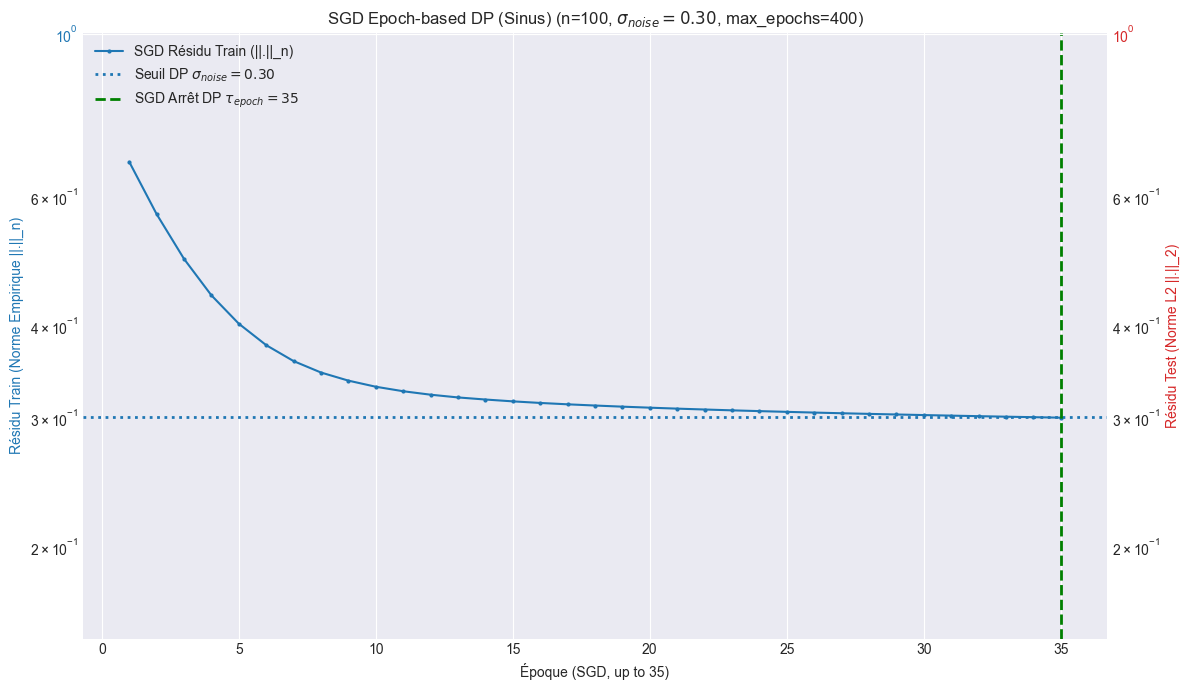

Error during SGD training or plotting: 'KernelRegressorSGD_DP' object has no attribute 'kernel_width'
###########################################

Script finished.


Traceback (most recent call last):
  File "C:\Users\djake\AppData\Local\Temp\ipykernel_14708\2359814282.py", line 379, in <module>
    Y_pred_sgd = model_sgd.predict(X_test)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\djake\AppData\Local\Temp\ipykernel_14708\2359814282.py", line 190, in predict
    K_new = gaussian_kernel(X_new, self.X, self.kernel_width) # Shape (n_new, n)
                                           ^^^^^^^^^^^^^^^^^
AttributeError: 'KernelRegressorSGD_DP' object has no attribute 'kernel_width'


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import math
import time # Pour mesurer le temps pour SGD

# ==========================================================
# Fonction Noyau Gaussien
# ==========================================================
def gaussian_kernel(X1, X2, width):
    """
    Matrice de Gram pour un noyau Gaussien.
    Implémentation vectorisée.
    """
    # Vérifications des entrées
    if X1.ndim == 1: X1 = X1.reshape(-1, 1)
    if X2.ndim == 1: X2 = X2.reshape(-1, 1)
    if X1.shape[1] != X2.shape[1]:
        raise ValueError(f"X1 features ({X1.shape[1]}) != X2 features ({X2.shape[1]})")
    if width <= 0:
        raise ValueError("kernel_width must be positive.")

    n1, d1 = X1.shape
    n2, d2 = X2.shape

    K = np.zeros((n1, n2))
    # Utiliser le broadcasting numpy
    for i in range(n1):
        diffs = X1[i, :] - X2 # Shape (n2, d)
        sq_distances = np.sum(diffs**2, axis=1) # Shape (n2,)
        K[i, :] = np.exp(-sq_distances / (2 * width**2))
    return K

# ==========================================================
# Classe: SGD avec Arrêt DP par Époque
# ==========================================================
class KernelRegressorSGD_DP:
    """
    Implémente la régression noyau par SGD.
    Arrêt DP vérifié après chaque ÉPOQUE: ||Y - K*alpha||_n <= sigma.
    """
    def __init__(self, X, Y, kernel_width):
        """Initialise le régresseur SGD."""
        self.X = X
        self.n = X.shape[0]
        if self.n == 0: raise ValueError("Input data X cannot be empty.")
        if Y.ndim == 1: self.Y = Y.reshape(-1, 1)
        elif Y.shape[0] != self.n or Y.shape[1] != 1: raise ValueError(f"Y shape mismatch")
        else: self.Y = Y

        print("Calculating Gram matrix K for SGD...")
        self.K = gaussian_kernel(self.X, self.X, kernel_width)
        print("Gram matrix K calculated.")

        self.alpha = np.zeros((self.n, 1))
        self.current_epoch = 0

    def _sgd_step(self, index, eta):
        """Effectue une étape de SGD."""
        prediction_i = self.K[index, :] @ self.alpha
        error_i = prediction_i - self.Y[index, 0]
        self.alpha -= eta * error_i * self.K[index, :].reshape(-1, 1)

    def train_sgd_dp(self, sigma_noise_level, max_epochs=100, eta=0.01,
                     X_test=None, Y_test_true=None, verbose_epoch=10):
        """Entraîne avec SGD et arrêt DP."""
        history = {'epoch': [], 'res_train_n': [], 'res_test_L2': [], 'time': []}
        tau_DP_epoch = max_epochs
        start_time_total = time.time()
        print(f"Starting SGD training for max {max_epochs} epochs...")

        for epoch in range(1, max_epochs + 1):
            epoch_start_time = time.time()
            self.current_epoch = epoch
            current_eta = eta(epoch) if callable(eta) else eta
            if current_eta <= 0:
                print(f"Warning: Eta <= 0 at epoch {epoch}. Stopping.")
                tau_DP_epoch = max(1, epoch - 1)
                break

            indices = np.random.permutation(self.n)
            for i in indices:
                self._sgd_step(i, current_eta)

            # Calcul Résidu Train (après époque) - Coût O(n^2)
            residual_vec = self.Y - (self.K @ self.alpha)
            current_residual_norm_n = float(np.sqrt(max(0, np.mean(residual_vec**2))))

            # Historique
            history['epoch'].append(epoch)
            history['res_train_n'].append(current_residual_norm_n)
            history['time'].append(time.time() - start_time_total)

            # Calcul Résidu Test
            test_res_val = np.nan
            if X_test is not None and Y_test_true is not None:
                try: test_res_val = self.residual_norm_test_epoch(X_test, Y_test_true)
                except Exception as e: print(f"Warn: Test residual error epoch {epoch}: {e}")
            history['res_test_L2'].append(test_res_val)

            # Affichage
            if epoch % verbose_epoch == 0 or epoch == 1 or epoch == max_epochs:
                 epoch_duration = time.time() - epoch_start_time
                 test_val_str = f"{test_res_val:.6f}" if not np.isnan(test_res_val) else "N/A"
                 print(f"Epoch {epoch}/{max_epochs} | Eta: {current_eta:.4g} | ResTrain_n: {current_residual_norm_n:.6f} | "
                       f"TestL2: {test_val_str} | Time: {epoch_duration:.2f}s")

            # Vérification Arrêt DP
            if not np.isnan(current_residual_norm_n) and current_residual_norm_n <= sigma_noise_level:
                print(f"DP threshold met at Epoch {epoch}")
                tau_DP_epoch = epoch
                break

            # Vérification Divergence
            divergence_threshold = 10 * sigma_noise_level + 2 * np.std(self.Y)
            if not np.isnan(current_residual_norm_n) and current_residual_norm_n > divergence_threshold:
                 print(f"Warn: Residual norm ({current_residual_norm_n:.2f}) > divergence threshold ({divergence_threshold:.2f}). Stopping.")
                 tau_DP_epoch = epoch
                 break

        history['tau_DP_epoch'] = max(1, tau_DP_epoch) if epoch >= 1 else 0
        total_time = time.time() - start_time_total
        print(f"SGD Training finished after {history['tau_DP_epoch']} epochs. Total time: {total_time:.2f}s")
        return history

    def predict(self, X_new):
        """Prédiction après entraînement."""
        current_alpha = self.alpha if hasattr(self, 'alpha') else np.zeros((self.n, 1))
        if X_new.ndim == 1: X_new = X_new.reshape(1, -1)
        if X_new.shape[1] != self.X.shape[1]: raise ValueError("X_new feature mismatch")
        K_new = gaussian_kernel(X_new, self.X, self.kernel_width)
        prediction = K_new @ current_alpha
        return prediction.ravel()

    def residual_norm_test_epoch(self, X_test, Y_test_true):
        """Calcule la norme L2 de l'erreur de test."""
        Y_pred = self.predict(X_test)
        Y_test_true_flat = Y_test_true.ravel()
        if Y_pred.shape != Y_test_true_flat.shape:
             print(f"Warn: Test shape mismatch {Y_pred.shape} vs {Y_test_true_flat.shape}")
             min_len = min(len(Y_pred), len(Y_test_true_flat))
             if min_len == 0: return np.nan
             diff = Y_pred[:min_len] - Y_test_true_flat[:min_len]
        else:
             diff = Y_pred - Y_test_true_flat
        return float(np.linalg.norm(diff))

# ==========================================================
# Bloc Principal d'Exécution (SGD UNIQUEMENT, SINUS, 400 ÉPOQUES)
# ==========================================================
if __name__ == "__main__":
    np.random.seed(43)
    plt.style.use('seaborn-v0_8-darkgrid')

    # === Paramètres ===
    n = 100
    kernel_width = 0.3
    sigma_noise = 0.3
    target_function_name = "Sinus"
    # <<< CHANGEMENT PRINCIPAL ICI >>>
    max_epochs_sgd = 400 # Étendre la durée de l'entraînement/calcul
    # ---
    # Taux d'apprentissage: Un pas constant peut diverger sur 400 époques.
    # Un pas décroissant est souvent plus sûr pour un long entraînement.
    # eta_sgd = 0.15 / n # Constant (risque de rebondir/diverger tardivement)
    eta_sgd = lambda epoch: (0.15 / n) / (1 + 0.005 * epoch) # Décroissant lentement
    verbose_frequency = 50 # Afficher moins souvent sur 400 époques

    print(f"--- Parameters ---")
    print(f"Target Function: {target_function_name}")
    print(f"Sample size n = {n}")
    print(f"Noise std dev sigma_noise = {sigma_noise:.2f}")
    print(f"Kernel width = {kernel_width}")
    print(f"Max epochs SGD: {max_epochs_sgd}") # Afficher la nouvelle limite
    print(f"Learning rate eta: {'Decaying function' if callable(eta_sgd) else eta_sgd}")
    print(f"-----------------------\n")

    # === Données (Cas Sinus) ===
    def ftrue_sinus(x_in):
        return np.sin(x_in).reshape(-1, 1)

    print("Generating data...")
    X_train = np.sort(np.random.uniform(-math.pi, math.pi, (n, 1)), axis=0)
    Y_train_true = ftrue_sinus(X_train)
    Y_train = Y_train_true + sigma_noise * np.random.randn(n, 1)
    X_test = np.linspace(-1.5 * math.pi, 1.5 * math.pi, 300).reshape(-1, 1)
    Y_test_true = ftrue_sinus(X_test)
    print("Data generated.")
    print("-----------------------\n")

    # === Exécution SGD avec DP par Époque ===
    print(f"########## SGD Epoch-based DP ({target_function_name}) ##########")
    print("Initializing SGD model...")
    model_sgd = None
    try:
        model_sgd = KernelRegressorSGD_DP(X_train, Y_train, kernel_width)
    except Exception as e:
        print(f"Error initializing SGD model: {e}")

    if model_sgd:
        print("\nStarting SGD training...")
        try:
            sgd_history = model_sgd.train_sgd_dp(
                sigma_noise_level=sigma_noise,
                max_epochs=max_epochs_sgd, # Utiliser la nouvelle limite
                eta=eta_sgd,
                X_test=X_test,
                Y_test_true=Y_test_true,
                verbose_epoch=verbose_frequency # Utiliser la fréquence ajustée
            )
            tau_DP_sgd_epoch = sgd_history['tau_DP_epoch']

            # --- Analyse Oracle Test ---
            t_oracle_sgd_epoch = -1
            res_test_L2_sgd = sgd_history['res_test_L2']
            epochs_sgd = sgd_history['epoch']
            if epochs_sgd and res_test_L2_sgd:
                valid_indices = ~np.isnan(res_test_L2_sgd)
                if np.any(valid_indices):
                    valid_residuals = np.array(res_test_L2_sgd)[valid_indices]
                    valid_epochs = np.array(epochs_sgd)[valid_indices]
                    if len(valid_residuals) > 0:
                        local_min_idx = np.nanargmin(valid_residuals)
                        t_oracle_sgd_epoch = valid_epochs[local_min_idx]
                        print(f"SGD Oracle Test minimum ({valid_residuals[local_min_idx]:.4f}) found at epoch={t_oracle_sgd_epoch}")
                    else: print("No valid test residuals for oracle.")
                else: print("All test results NaN or missing.")
            else: print("SGD history empty.")

            # --- Affichage Courbes Résidus ---
            if len(epochs_sgd) > 0:
                fig_sgd, ax1_sgd = plt.subplots(figsize=(12, 7))
                ax2_sgd = ax1_sgd.twinx()
                ax1_sgd.plot(epochs_sgd, sgd_history['res_train_n'], color='tab:blue', label='SGD Résidu Train (||.||_n)', marker='.', markersize=3, linestyle='-')
                ax1_sgd.axhline(sigma_noise, color='tab:blue', ls=':', lw=2, label=f'Seuil DP $\sigma_{{noise}}={sigma_noise:.2f}$')
                if 'valid_indices' in locals() and np.any(valid_indices):
                    ax2_sgd.plot(valid_epochs, valid_residuals, color='tab:red', label='SGD Résidu Test (||.||_2)', marker='.', markersize=3, linestyle='-')
                ax1_sgd.axvline(tau_DP_sgd_epoch, color='green', ls='--', lw=2, label=f'SGD Arrêt DP $\\tau_{{epoch}}={tau_DP_sgd_epoch}$')
                if t_oracle_sgd_epoch != -1: ax1_sgd.axvline(t_oracle_sgd_epoch, color='purple', ls='-.', lw=1.5, label=f'SGD Oracle Test $epoch={t_oracle_sgd_epoch}$')
                ax1_sgd.set_xlabel(f'Époque (SGD, up to {epochs_sgd[-1]})')
                ax1_sgd.set_ylabel('Résidu Train (Norme Empirique ||.||_n)', color='tab:blue')
                ax2_sgd.set_ylabel('Résidu Test (Norme L2 ||.||_2)', color='tab:red')
                ax1_sgd.tick_params(axis='y', labelcolor='tab:blue')
                ax2_sgd.tick_params(axis='y', labelcolor='tab:red')
                ax1_sgd.set_yscale('log')
                ax2_sgd.set_yscale('log')
                # Limites Y robustes
                all_valid_res = [v for v in sgd_history['res_train_n'] + res_test_L2_sgd if v is not None and v > 1e-9 and np.isfinite(v)] or [1e-9]
                min_y, max_y = min(all_valid_res), max([v for v in all_valid_res if np.isfinite(v)] + [sigma_noise] or [1.0])
                ax1_sgd.set_ylim(bottom=max(1e-9, min_y * 0.5), top=max_y * 1.5)
                ax2_sgd.set_ylim(bottom=max(1e-9, min_y * 0.5), top=max_y * 1.5)
                # Légende
                lines1, labels1 = ax1_sgd.get_legend_handles_labels()
                lines2, labels2 = ax2_sgd.get_legend_handles_labels()
                lines = lines1 + [l for i, l in enumerate(lines2) if labels2[i]]
                labels = labels1 + [l for l in labels2 if l]
                if lines: ax1_sgd.legend(lines, labels, loc='best')
                plt.title(f"SGD Epoch-based DP ({target_function_name}, up to 400 epochs) (n={n}, $\sigma={sigma_noise:.2f}$)")
                fig_sgd.tight_layout()
                plt.show()

                # --- Affichage Prédiction Finale ---
                Y_pred_sgd = model_sgd.predict(X_test)
                plt.figure(figsize=(10, 6))
                plt.scatter(X_train, Y_train, alpha=0.5, s=10, label='Données Train (bruité)')
                plt.plot(X_test, Y_test_true.ravel(), 'k-', lw=2, label=f'Vraie Fonction ({target_function_name})')
                plt.plot(X_test, Y_pred_sgd, 'g--', lw=2, label=f'Prédiction SGD DP (epoch={tau_DP_sgd_epoch})')
                plt.title(f"Prédiction Finale SGD DP (epoch={tau_DP_sgd_epoch}, {target_function_name})")
                plt.xlabel("X"); plt.ylabel("Y"); plt.legend(); plt.grid(True)
                plt.ylim(Y_test_true.min() - sigma_noise*3, Y_test_true.max() + sigma_noise*3)
                plt.show()
            else: print("SGD history empty, cannot plot.")
        except Exception as e:
            print(f"Error during SGD training/plotting: {e}")
            import traceback
            traceback.print_exc()
    else: print("SGD model init failed.")

    print("###########################################\n")
    print("Script finished.")

# Aperçu du Code

Ce code implémente un régresseur à noyau utilisant la méthode de Landweber avec une règle d'arrêt basée sur la différenciation privée (SDP). Il inclut des calculs pour des résidus d'entraînement et de test, ainsi qu'une visualisation des résultats.

## Importations

- **numpy** : Opérations mathématiques et manipulation des tableaux.
- **matplotlib.pyplot** : Tracé de graphiques.
- **math** : Fonctions mathématiques de base.

## Fonctions et Méthodes

- **`gaussian_kernel(X1, X2, width)`**
  - Calcule la matrice de Gram pour un noyau gaussien.

- **Classe `KernelRegressorSpectralLandweberSDP`**
  - **`__init__(self, X, Y, kernel_width, T_smooth_iterations)`**
    - Initialise le régresseur avec les données d'entraînement et les paramètres du noyau.
  - **`alpha_t(self, t)`**
    - Calcule les coefficients alpha à l'itération `t`.
  - **`predict_t(self, X_new, t)`**
    - Prédit les valeurs pour de nouvelles données `X_new` à l'itération `t`.
  - **`residual_norm_test_t(self, X_test, Y_test_true, t)`**
    - Calcule la norme L2 du résidu de test à l'itération `t`.
  - **`calculate_g_tilde_Landweber_T_diag(self)`**
    - Calcule la matrice diagonale pour le lissage Landweber.
  - **`calculate_D_Ln(self)`**
    - Calcule la matrice diagonale `D_Ln`.
  - **`squared_smoothed_residual_norm_empirique_t(self, t)`**
    - Calcule la norme empirique lissée au carré du résidu d'entraînement à l'itération `t`.
  - **`calculate_N_tilde_g_T(self)`**
    - Calcule la dimension effective lissée.
  - **`find_tau_SDP(self, sigma_noise_level, max_t=600)`**
    - Trouve l'itération d'arrêt basée sur la règle SDP.

Actual noise std dev (sigma_noise) for epsilon_i: 1.0

Initializing SDP model...
INFO: Using Landweber-type smoothing for SDP with T_smooth=20 iterations and eta=0.0200
Calculated D_Ln matrix for SDP smoothing.
SDP Model initialized.
Landweber step size eta = 0.02001
Smoothed effective dimension N_n^g(T) (for K) = 16.6957
Smoothed effective dimension per sample (N/n) = 0.1670

Calculating residuals up to t=1000 (SDP)...
  Iteration 1/1000
  Iteration 100/1000
  Iteration 200/1000
  Iteration 300/1000
  Iteration 400/1000
  Iteration 500/1000
  Iteration 600/1000
  Iteration 700/1000
  Iteration 800/1000
  Iteration 900/1000
  Iteration 1000/1000
Residual calculation finished.

Finding SDP stopping iteration (Landweber smoothing)...
SDP Threshold ||L_n(...) ||_n^2 <= sigma^2 * (N/n) = 0.166957
SDP searching up to t=1000
  SDP Check t=1: Smoothed Residual Norm^2_n = 0.575917
SDP Condition met at t=6
SDP stopping iteration found: tau_SDP = 6
Test residual norm ||.||_2 at tau_SDP: 5.8994
M

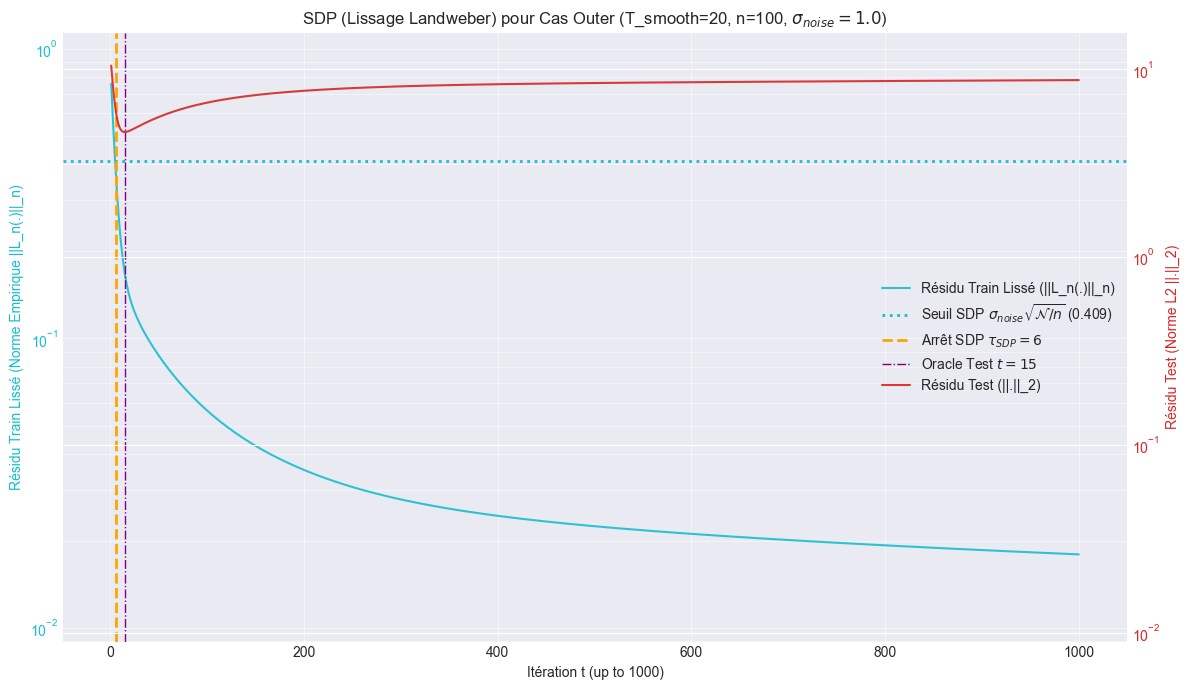

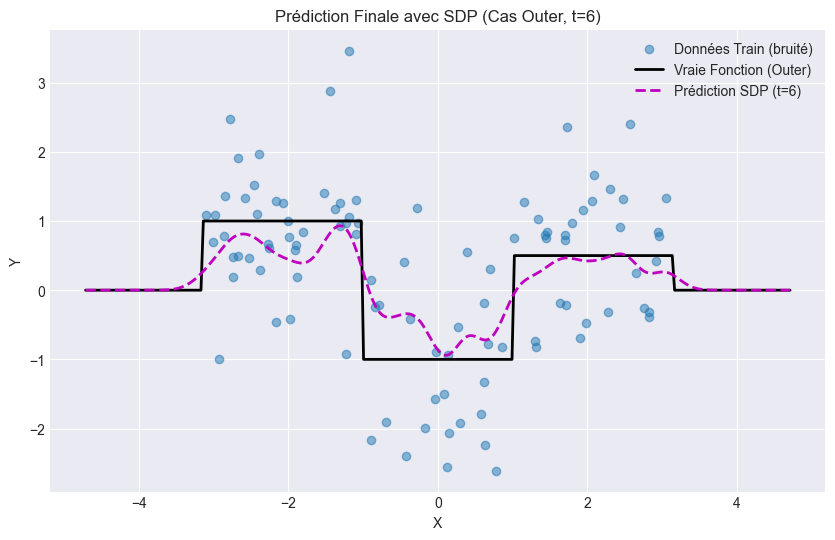

: 

In [ ]:
1# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import math

# La fonction gaussian_kernel est la même que dans le Code 1
def gaussian_kernel(X1, X2, width):
    """Matrice de Gram pour un noyau Gaussien."""
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            diff = X1[i] - X2[j]
            K[i,j] = np.exp(-np.sum(diff**2)/(2*width**2))
    return K

class KernelRegressorSpectralLandweberSDP:
    """
    Régresseur noyau par Landweber spectral.
    Inclut le calcul de la règle d'arrêt SDP.
    MODIFIÉ : Utilise un lissage de type Landweber pour SDP (différent de l'article principal).
    Basé sur K (pas K_n = K/n).
    """
    def __init__(self, X, Y, kernel_width, T_smooth_iterations):
        """
        T_smooth_iterations: Nombre d'itérations pour le filtre de lissage Landweber g_tilde_T
        """
        self.X = X
        self.n = X.shape[0]
        if Y.ndim == 1:
            Y = Y.reshape(-1,1)
        self.Y = Y # Vecteur (n,1)
        self.kernel_width = kernel_width
        self.T_smooth_iterations = int(max(1, T_smooth_iterations))

        self.K = gaussian_kernel(X, X, kernel_width)

        try:
            vals, vecs = np.linalg.eigh(self.K)
        except np.linalg.LinAlgError:
             print("Eigendecomposition failed for K. Matrix might be ill-conditioned.")
             epsilon = 1e-10 * np.eye(self.n)
             vals, vecs = np.linalg.eigh(self.K + epsilon)

        vals = np.maximum(vals, 0)
        idx = np.argsort(vals)[::-1]
        self.lambdas = vals[idx]
        self.Q = vecs[:, idx]

        self.lmax = max(self.lambdas[0], 1e-14)

        # --- MODIFICATION: Utiliser un eta plus raisonnable ---
        self.eta = 0.2 / self.lmax # Augmenté par rapport à 0.01/lmax

        self.QTY = self.Q.T @ self.Y

        print(f"INFO: Using Landweber-type smoothing for SDP with T_smooth={self.T_smooth_iterations} iterations and eta={self.eta:.4f}")
        self.g_tilde_T_diag_matrix = self.calculate_g_tilde_Landweber_T_diag()
        # --- MODIFICATION: Stocker D_Ln lors du calcul ---
        self.D_Ln = self.calculate_D_Ln() # Calcule et stocke D_Ln
        self.N_n_tilde_g_T = self.calculate_N_tilde_g_T()

    # ... (alpha_t, predict_t, residual_norm_test_t restent inchangés) ...
    def alpha_t(self, t):
        """
        Calcule alpha^(t) tel que f_hat^(t) = K @ alpha^(t).
        alpha^(t) = g_t(K)*Y = Q g_t(Lambda) Q^T Y
        où g_t(lambda) = (1/lambda)*(1 - (1 - eta*lambda)^t) pour K.
        """
        t_iter = int(max(1,t))
        gvals = []
        for l in self.lambdas:
            if l < 1e-14:
                gvals.append(self.eta * t_iter)
            else:
                term = 1.0 - self.eta * l
                term = max(min(term, 1.0), -1.0)
                gvals.append( (1.0/l) * (1.0 - term**t_iter ) )

        G_diag = np.diag(gvals)
        alpha = self.Q @ G_diag @ self.QTY # Taille (n,1)
        return alpha

    def predict_t(self, X_new, t):
        """
        Prédiction: f_hat^(t)(X_new) = k(X_new, X) @ alpha_t(t)
        """
        alpha = self.alpha_t(t)
        K_new = gaussian_kernel(X_new, self.X, self.kernel_width) # Taille (n_new, n)
        prediction = K_new @ alpha # Taille (n_new, 1)
        return prediction.ravel() # Retourne un vecteur 1D

    def residual_norm_test_t(self, X_test, Y_test_true, t):
        """
        Calcule la norme L2 standard de la différence sur l'ensemble de test:
          || f_hat^(t)(X_test) - f_true(X_test) ||_2
        """
        Y_pred = self.predict_t(X_test, t) # Taille (n_test,)
        Y_test_true_flat = Y_test_true.ravel() # Taille (n_test,)
        diff = Y_pred - Y_test_true_flat
        return float(np.linalg.norm(diff)) # Norme L2 standard

    # ---------------------------
    # Lissage SDP (MODIFIÉ : type Landweber)
    # ---------------------------
    def calculate_g_tilde_Landweber_T_diag(self):
        """Calcule g_tilde_T(Lambda) en utilisant Landweber."""
        g_tilde_vals = []
        T_iter = self.T_smooth_iterations
        for l in self.lambdas:
            if l < 1e-14:
                g_tilde_vals.append(self.eta * T_iter)
            else:
                term = 1.0 - self.eta * l
                term = max(min(term, 1.0), -1.0)
                g_tilde_vals.append( (1.0/l) * (1.0 - term**T_iter ) )
        return np.diag(g_tilde_vals)

    # --- MODIFICATION: Fonction séparée pour calculer D_Ln ---
    def calculate_D_Ln(self):
        """Calcule la matrice diagonale D_Ln = diag(sqrt(g_tilde_T(lambda_j) * lambda_j))."""
        g_tilde_diag_values = np.diag(self.g_tilde_T_diag_matrix)
        combined_values = np.maximum(g_tilde_diag_values * self.lambdas, 0)
        D_Ln = np.diag(np.sqrt(combined_values))
        print("Calculated D_Ln matrix for SDP smoothing.")
        return D_Ln

    # --- MODIFICATION: Calcul optimisé du résidu lissé ---
    def squared_smoothed_residual_norm_empirique_t(self, t):
        """ Version optimisée utilisant les transformations spectrales """
        t_iter = int(max(1, t))
        rvals = []
        for l in self.lambdas:
            term = 1.0 - self.eta * l
            term = max(min(term, 1.0), -1.0)
            rvals.append(term**t_iter)
        R_diag_vec = np.array(rvals).reshape(-1, 1) # Vecteur colonne des valeurs r_t(lambda)

        # Calculer D_Ln @ R_diag @ QTY dans l'espace spectral
        spectral_smoothed_residual_coeffs = np.diag(self.D_Ln).reshape(-1, 1) * R_diag_vec * self.QTY

        # Norme L2 au carré dans l'espace spectral == norme L2 dans l'espace original
        squared_norm_L2 = np.sum(spectral_smoothed_residual_coeffs**2)

        # Norme empirique au carré
        squared_norm_empirique = (1.0 / self.n) * squared_norm_L2
        return float(max(0, squared_norm_empirique))

    def calculate_N_tilde_g_T(self):
        """Calcule N_n^{tilde{g}}(T) = tr(K * g_tilde_T(K))."""
        g_tilde_diag_values = np.diag(self.g_tilde_T_diag_matrix)
        N_val = np.sum(self.lambdas * g_tilde_diag_values)
        return float(max(0, N_val))

    # ---------------------------
    # Règle d'arrêt SDP (Eq. 4.1 du papier, adaptée)
    # ---------------------------
    def find_tau_SDP(self, sigma_noise_level, max_t=600):
        """Trouve tau_SDP en comparant || L_n (...) ||_n^2 au seuil."""
        if sigma_noise_level < 0:
            raise ValueError("sigma (noise level std dev) must be non-negative.")
        if self.n == 0: return 0

        threshold = (sigma_noise_level**2) * (self.N_n_tilde_g_T / self.n)
        print(f"SDP Threshold ||L_n(...) ||_n^2 <= sigma^2 * (N/n) = {threshold:.6f}")

        max_t_iter = int(max(1, max_t))
        print(f"SDP searching up to t={max_t_iter}")

        for t in range(1, max_t_iter + 1):
            smoothed_res_sq_norm_emp = self.squared_smoothed_residual_norm_empirique_t(t)
            if t % 50 == 0 or t == 1 or t == max_t_iter:
                 print(f"  SDP Check t={t}: Smoothed Residual Norm^2_n = {smoothed_res_sq_norm_emp:.6f}")
            if smoothed_res_sq_norm_emp <= threshold:
                print(f"SDP Condition met at t={t}")
                return t
        print(f"SDP Condition not met by max_t={max_t_iter}. Returning max_t.")
        return max_t_iter

# --------------------------------------------------------------------------
# Exemple d'utilisation : SDP appliqué au cas OUTER
# --------------------------------------------------------------------------
if __name__ == "__main__":
    np.random.seed(42)

    # Paramètres
    n = 100
    kernel_width = 0.2
    max_t = 1000 # Nombre d'itérations pour l'algo principal et affichage
    T_smooth_iterations_sdp = 20 # Paramètre pour le lissage Landweber

    # --- Génération du bruit ---
    sigma_noise = 1.0 # Écart-type réel des erreurs epsilon_i
    print(f"Actual noise std dev (sigma_noise) for epsilon_i: {sigma_noise}")
    noise_generator_std_dev = sigma_noise

    # --- Données train pour un cas OUTER ---
    def ftrue_outer(x_in):
        res = np.zeros_like(x_in)
        res[(x_in >= -math.pi) & (x_in < -1)] = 1.0
        res[(x_in >= -1) & (x_in < 1)] = -1.0
        res[(x_in >= 1) & (x_in <= math.pi)] = 0.5
        return res.reshape(-1, 1)

    X_train = np.sort(np.random.uniform(-math.pi, math.pi, (n,1)), axis=0)
    Y_train_true = ftrue_outer(X_train)
    Y_train = Y_train_true + noise_generator_std_dev * np.random.randn(n,1)

    # Données test
    X_test = np.linspace(-1.5*math.pi, 1.5*math.pi, 300).reshape(-1,1)
    Y_test_true = ftrue_outer(X_test)

    # Création du modèle SDP
    print("\nInitializing SDP model...")
    # --- MODIFICATION : Passer le bon sigma_noise pour le seuil ---
    model_sdp = KernelRegressorSpectralLandweberSDP(X_train, Y_train, kernel_width, T_smooth_iterations_sdp)
    print("SDP Model initialized.")
    print(f"Landweber step size eta = {model_sdp.eta:.4g}")
    print(f"Smoothed effective dimension N_n^g(T) (for K) = {model_sdp.N_n_tilde_g_T:.4f}")
    print(f"Smoothed effective dimension per sample (N/n) = {model_sdp.N_n_tilde_g_T / n:.4f}")

    # Courbes
    t_vals = range(1, max_t + 1)
    residual_test_norm_L2_list = []
    smoothed_residual_train_norm_emp_list = [] # Norme empirique lissée sqrt(||L_n(.)||_n^2)

    print(f"\nCalculating residuals up to t={max_t} (SDP)...")
    for i, t in enumerate(t_vals):
        if (i + 1) % 100 == 0 or t == 1:
            print(f"  Iteration {t}/{max_t}")
        try:
            r_test_norm = model_sdp.residual_norm_test_t(X_test, Y_test_true, t)
            smoothed_r_train_sq_norm_emp = model_sdp.squared_smoothed_residual_norm_empirique_t(t)

            residual_test_norm_L2_list.append(r_test_norm)
            smoothed_residual_train_norm_emp_list.append(np.sqrt(max(0, smoothed_r_train_sq_norm_emp)))
        except Exception as e:
            print(f"Error calculating residuals at t={t}: {e}")
            residual_test_norm_L2_list.append(np.nan)
            smoothed_residual_train_norm_emp_list.append(np.nan)
            # max_t = t - 1
            # t_vals = range(1, max_t + 1)
            # break
    print("Residual calculation finished.")

    # Trouver l'itération d'arrêt SDP
    print("\nFinding SDP stopping iteration (Landweber smoothing)...")
    tau_SDP = model_sdp.find_tau_SDP(sigma_noise_level=sigma_noise, max_t=max_t)
    print(f"SDP stopping iteration found: tau_SDP = {tau_SDP}")

    # Valeur du résidu test à l'arrêt SDP
    if tau_SDP <= max_t and not np.isnan(residual_test_norm_L2_list[tau_SDP-1]):
        res_test_at_tau_sdp = residual_test_norm_L2_list[tau_SDP-1]
        print(f"Test residual norm ||.||_2 at tau_SDP: {res_test_at_tau_sdp:.4f}")
    else:
        print(f"Cannot show test residual at tau_SDP={tau_SDP}.")

    # Affichage
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Axe 1: Résidu train lissé (norme empirique ||L_n(.)||_n) et seuil SDP
    color = 'tab:cyan'
    ax1.set_xlabel(f"Itération t (up to {max_t})")
    ax1.set_ylabel("Résidu Train Lissé (Norme Empirique ||L_n(.)||_n)", color=color)
    ax1.plot(t_vals[:len(smoothed_residual_train_norm_emp_list)], smoothed_residual_train_norm_emp_list, color=color, label='Résidu Train Lissé (||L_n(.)||_n)', alpha=0.9)
    ax1.tick_params(axis='y', labelcolor=color)

    # Seuil SDP = sigma_noise * sqrt( N / n )
    sdp_threshold_norm = sigma_noise * np.sqrt(max(0, model_sdp.N_n_tilde_g_T / n))
    ax1.axhline(sdp_threshold_norm, color=color, ls=':', lw=2, label=f"Seuil SDP $\\sigma_{{noise}} \\sqrt{{\\mathcal{{N}}/n}}$ ({sdp_threshold_norm:.3f})")

    # Axe 2: Résidu test (norme L2)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Résidu Test (Norme L2 ||.||_2)", color=color)
    ax2.plot(t_vals[:len(residual_test_norm_L2_list)], residual_test_norm_L2_list, color=color, label='Résidu Test (||.||_2)', alpha=0.9)
    ax2.tick_params(axis='y', labelcolor=color)

    # Ligne verticale pour l'arrêt SDP
    ax1.axvline(tau_SDP, color='orange', ls='--', lw=2, label=f"Arrêt SDP $\\tau_{{SDP}}={tau_SDP}$")

    # Trouver l'oracle test
    valid_test_residuals = [r for r in residual_test_norm_L2_list if not np.isnan(r)]
    if valid_test_residuals:
        min_test_res_idx = np.nanargmin(residual_test_norm_L2_list)
        t_oracle_test = t_vals[min_test_res_idx]
        min_test_res_val = residual_test_norm_L2_list[min_test_res_idx]
        ax1.axvline(t_oracle_test, color='purple', ls='-.', lw=1, label=f'Oracle Test $t={t_oracle_test}$')
        print(f"Minimum Test residual norm ||.||_2 = {min_test_res_val:.4f} at t={t_oracle_test}")

    # Configuration du graphique
    valid_smoothed_residuals = [r for r in smoothed_residual_train_norm_emp_list if not np.isnan(r)]
    min_smooth = min(valid_smoothed_residuals) if valid_smoothed_residuals else 1e-3
    max_smooth = max(valid_smoothed_residuals) if valid_smoothed_residuals else 1.0
    min_test = min(valid_test_residuals) if valid_test_residuals else 1e-3
    max_test = max(valid_test_residuals) if valid_test_residuals else 1.0

    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_ylim(bottom=min(min_smooth, min_test) * 0.5, top=max(max_smooth, sdp_threshold_norm) * 1.5)
    ax2.set_ylim(bottom=min(min_smooth, min_test) * 0.5, top=max_test * 1.5)
    ax1.grid(True, which="both", ls="-", alpha=0.5)

    # Légendes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    plt.title(f"SDP (Lissage Landweber) pour Cas Outer (T_smooth={T_smooth_iterations_sdp}, n={n}, $\sigma_{{noise}}={sigma_noise:.1f}$)")
    fig.tight_layout()
    plt.show()

    # Affichage de la prédiction à l'arrêt SDP
    if tau_SDP <= max_t and not np.isnan(residual_test_norm_L2_list[tau_SDP-1]):
        Y_pred_final_sdp = model_sdp.predict_t(X_test, tau_SDP)
        plt.figure(figsize=(10, 6))
        plt.scatter(X_train, Y_train, alpha=0.5, label='Données Train (bruité)')
        plt.plot(X_test, Y_test_true.ravel(), 'k-', lw=2, label='Vraie Fonction (Outer)')
        plt.plot(X_test, Y_pred_final_sdp, 'm--', lw=2, label=f'Prédiction SDP (t={tau_SDP})')
        plt.title(f"Prédiction Finale avec SDP (Cas Outer, t={tau_SDP})")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Cannot plot final SDP prediction.")